# Imports

In [1]:
import webdriver_manager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.chrome.service import Service as ChromeService
from IPython.display import clear_output
import time
import pandas as pd
import IPython
import os
from decouple import config
import re

# Driver and Functions

In [2]:
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))

[WDM] - Downloading: 100%|██████████| 6.96M/6.96M [00:01<00:00, 4.63MB/s]


In [3]:
def login():
    driver.get("https://ocs.iitd.ac.in/portal/login")
    ID = config("OCS_ID")
    password = config("OCS_PASSWORD")
    driver.get("https://ocs.iitd.ac.in/portal/login")
    driver.find_element(By.ID, "mat-input-0").send_keys(ID)
    driver.find_element(By.ID, "mat-input-1").send_keys(password)
    captcha = driver.find_element(By.TAG_NAME, "object")
    captcha.screenshot("captcha.png")
    IPython.display.display(IPython.display.Image("captcha.png"))
    captcha_code = input("Enter the captcha code: ")
    driver.find_element(By.ID, "mat-input-2").send_keys(captcha_code)
    driver.find_element(By.TAG_NAME, "button").click()

In [4]:
def list_companies(url = "https://ocs.iitd.ac.in/portal/student/applications", class1= "mat-select-value-5", class2 = "mat-option-14"):
    driver.get(url)
    driver.find_element(By.ID, class1).click()
    driver.find_element(By.ID, class2).click()
    max_rows = int(driver.find_element(By.CLASS_NAME, "mat-paginator-range-label").text.split(" ")[-1])
    return max_rows

In [5]:
def result(max_rows):
    companies = []
    profiles = []
    page_num = 0
    per_page = 50
    while page_num*per_page<=max_rows:
        print(f"Currently on page {page_num+1}", end="\r")
        table = driver.find_element(By.TAG_NAME, "table")
        rows = table.find_elements(By.TAG_NAME, "tr")
        for i in range(1, len(rows)):
            data = rows[i].find_element(By.TAG_NAME, "td").text.split("\n")[0]
            company = data.split("(")[0]
            profile = data.split("(")[1].split(")")[0]
            companies.append(company.strip())
            profiles.append(profile.strip())
        next_btn = driver.find_elements(By.CLASS_NAME, "mat-button-wrapper")[1]
        next_btn.click()
        page_num+=1
    all_companies = pd.DataFrame([companies, profiles]).T
    all_companies.columns = ["Company", "Profile"]
    return all_companies

In [6]:
def logout():
    for item in driver.find_elements(By.TAG_NAME ,"mat-icon"):
        if item.text == "exit_to_app":
            item.click()
            return None

# Start

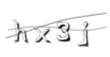

In [7]:
login()
os.remove("captcha.png")

## MSC List

In [9]:
max_rows = list_companies()
msc_df = result(max_rows=max_rows)

In [10]:
msc_df

,Company,Profile
0,Infoglen LLC,Salesforce Technology Freshers
1,IntelliBlock Technologies Private Limited,Blockchain Developer
2,ProtoTech Solutions,Associate Software Developer
3,Polyone Polymers India Pvt. Ltd.,R&D Chemist
4,Optimum,Core Role
...,...,...
64,Agnikul Cosmos Pvt Ltd,Additive Manufacturing Specialist
65,Agnikul Cosmos Pvt Ltd,LabVIEW Engineer
66,Agnikul Cosmos Pvt Ltd,Launch Vehicle Composites Engineer
67,Advantage Club,iOS Developer


## All List

In [8]:
url = "https://ocs.iitd.ac.in/portal/student/companies"
class1= "mat-select-value-3"
class2 = "mat-option-10"
max_rows = list_companies(url = url, class1=class1, class2=class2)
all_df = result(max_rows=max_rows)

In [9]:
all_df

,Company,Profile
0,Air India,Digital Technology Trainee - NLP
1,Air India,Digital Technology Trainee – CRM Platform Tech...
2,Air India,Digital Technology Trainee- E Ops
3,Air India,Digital Technology Trainees – Business Analyst
4,Air India,Digital Technology Trainees – Data Analyst
...,...,...
390,Virohan Private Limited,Associate Product Manager
391,Vyapar App,Software Developer
392,www.enerzinx.com,Application Engineer - I
393,Zen Linen International Private Limited,Management Engineer Trainee


In [10]:
logout()

In [11]:
driver.close()

# Analysis

## Loading the Older List

In [12]:
msc_old = pd.read_csv("msc.csv")
all_old = pd.read_csv("all.csv")

## Comparing

In [12]:
if len(msc_old)!=len(msc_df):
    print("Some things have changed!")
    changed = True
else:
    print("Everything is the Same.")
    changed = False

Some things have changed!


In [13]:
if changed:
    diff = len(msc_old)-len(msc_df)
    if diff<0:
        print(f"A total of {-diff} Positions have been ADDED.")
    else:
        print(f"A total of {diff} Positions have been REMOVED.")
else:
    diff = 0

A total of 103 Positions have been REMOVED.


In [14]:
def compare(diff = diff, anyway = False):
    old_list = msc_old["Company"].values +" "+ msc_old["Profile"].values
    new_list = msc_df["Company"].values +" "+ msc_df["Profile"].values
    if diff<0 or anyway:
        print("Added Positions are:\n")
        for c in new_list:
            if c not in old_list:
                print(c)
    elif diff>0 or anyway:
        print("Removed Positions are:\n")
        for c in old_list:
            if c not in new_list:
                print(c)

In [15]:
compare(diff = diff, anyway = True)

Added Positions are:



## Saving the Latest List

In [16]:
msc_df.to_csv("msc.csv", index=False)
# all_df.to_csv("all.csv", index=False)

In [20]:
# all_df

In [17]:
msc_df

,Company,Profile
0,Infoglen LLC,Salesforce Technology Freshers
1,IntelliBlock Technologies Private Limited,Blockchain Developer
2,ProtoTech Solutions,Associate Software Developer
3,Polyone Polymers India Pvt. Ltd.,R&D Chemist
4,Optimum,Core Role
...,...,...
64,Agnikul Cosmos Pvt Ltd,Additive Manufacturing Specialist
65,Agnikul Cosmos Pvt Ltd,LabVIEW Engineer
66,Agnikul Cosmos Pvt Ltd,Launch Vehicle Composites Engineer
67,Advantage Club,iOS Developer


In [22]:
msc_df["Company"].value_counts()

Sony Group Corporation                  12
Agnikul Cosmos Pvt Ltd                  11
MIKO                                    10
Fast Retailing                           7
FourthFrontier                           7
                                        ..
Raphe mPhibr Pvt Ltd                     1
Aganitha Cognitive Solutions Pvt Ltd     1
Godrej Capital                           1
Vantage Research                         1
Racyics GmbH                             1
Name: Company, Length: 85, dtype: int64

# Saving All Companies

In [ ]:
Stop

In [33]:
def save_html(max_rows):
    companies = []
    profiles = []
    file_links = []
    page_num = 14
    per_page = 50
    while page_num*per_page<=max_rows:
        # print(f"Currently on page {page_num+1}", end="\r")
        table = driver.find_element(By.TAG_NAME, "table")
        rows = table.find_elements(By.TAG_NAME, "tr")
        for i in range(1, len(rows)):
            print(f"Currently on page {page_num+1} and row {i}", end="\r")
            data = rows[i].find_element(By.TAG_NAME, "td").text.split("\n")[0]
            company = data.split("(")[0]
            profile = data.split("(")[1].split(")")[0]
            companies.append(company.strip())
            profiles.append(profile.strip())

            #Get the file name
            name = company.strip()+" "+profile.strip()
            #remove any special characters
            name = re.sub(r"[^a-zA-Z0-9_\s]", "", name)
            if len(name)>60:
                name = name[:60]
            name = os.path.join("All", name)
            file_name = f"{name}_{page_num * 50 + i}.html"
            file_links.append(file_name)

            #Open the link
            rows[i].find_elements(By.TAG_NAME, "td")[0].click()
            # switch to new window
            driver.switch_to.window(driver.window_handles[1])
            time.sleep(1)
            # save the html
            with open(file_name, "w") as f:
                f.write(driver.page_source)
            # close the window
            driver.close()
            # switch back to main window
            driver.switch_to.window(driver.window_handles[0])
            
        next_btn = driver.find_elements(By.CLASS_NAME, "mat-button-wrapper")[1]
        next_btn.click()
        page_num+=1
    all_companies = pd.DataFrame([companies, profiles]).T
    all_companies.columns = ["Company", "Profile"]
    return all_companies, file_links

In [31]:
max_rows = max_rows+150

In [32]:
max_rows

835

In [34]:
all_cs, file_links = save_html(max_rows=max_rows)

In [35]:
logout()

In [36]:
all_cs["File"] = file_links

In [37]:
all_cs.to_csv("all_companies.csv", index=False)

# More Info

In [12]:
import glob
import bs4
import tqdm
import pandas as pd
import re

In [2]:
files = glob.glob("All/*.html")
sample = files[0]

with open(sample, "r") as f:
    html = f.read()

soup = bs4.BeautifulSoup(html, "html.parser")

In [6]:
tables = soup.find_all("table")
ct = tables[0]
jt = tables[1]
st = tables[2]
spt = tables[3]

In [7]:
company_name = ct.find_all("tr")[0].find_all("td")[1].text
designation = jt.find_all("tr")[0].find_all("td")[1].text
print(company_name, designation)

1K Kirana Bazaar Product Analyst


In [8]:
ctc = st.find_all("tr")[0].find_all("td")[1].text
ctc_num = ctc.split(" ")[0]
ctc_unit = ctc.split(" ")[1]
gross_ctc = st.find_all("tr")[1].find_all("td")[1].text
gross_ctc_num = gross_ctc.split(" ")[0]
gross_ctc_unit = gross_ctc.split(" ")[1]
base = st.find_all("tr")[2].find_all("td")[1].text
base_num = base.split(" ")[0]
base_unit = base.split(" ")[1]
print(ctc_num, ctc_unit)
print(gross_ctc_num, gross_ctc_unit)
print(base_num, base_unit)

1,500,000 INR
1,478,400 INR
750,000 INR


In [23]:
spt.text

'Resume Shortlist:YesWritten Test:NoOnline Test:YesGroup Discussion:NoMedical Test:NoPersonal Interview:YesNo. of Rounds:4No. of Offers:2Minimum CGPA:7'

In [28]:
regex = re.compile(r"Offers:(\d+)")
offers = regex.findall(spt.text)
if offers:
    offers = int(offers[0])
else:
    offers = 0
print(offers)

2


In [24]:

match = re.match(r"Offers:\d",
    spt.text)
match

In [37]:
def get_details(file):
    with open(file, "r") as f:
        html = f.read()

    soup = bs4.BeautifulSoup(html, "html.parser")
    tables = soup.find_all("table")
    ct = tables[0]
    jt = tables[1]
    st = tables[2]
    spt = tables[3]
    company_name = ct.find_all("tr")[0].find_all("td")[1].text
    designation = jt.find_all("tr")[0].find_all("td")[1].text
    def convert_unit(unit):
        if unit.lower() == "inr":
            return ""
        else:
            return unit
    ctc = st.find_all("tr")[0].find_all("td")[1].text
    ctc_num = ctc.split(" ")[0]
    ctc_unit = ctc.split(" ")[1]
    ctc = f"{ctc_num} {convert_unit(ctc_unit)}".strip()

    gross_ctc = st.find_all("tr")[1].find_all("td")[1].text
    gross_ctc_num = gross_ctc.split(" ")[0]
    gross_ctc_unit = gross_ctc.split(" ")[1]
    gross_ctc = f"{gross_ctc_num} {convert_unit(gross_ctc_unit)}".strip()

    base = st.find_all("tr")[2].find_all("td")[1].text
    base_num = base.split(" ")[0]
    base_unit = base.split(" ")[1]
    base = f"{base_num} {convert_unit(base_unit)}".strip()

    regex = re.compile(r"Offers:(\d+)")
    offers = regex.findall(spt.text)
    if offers:
        offers = int(offers[0])
    else:
        offers = 0
    if offers>100:
        return [None, None, None, None, None, 0]

    return [company_name, designation, ctc, gross_ctc, base, offers]

In [38]:
detils = []
for i in tqdm.tqdm(range(len(files))):
    try:
        detils.append(get_details(files[i]))
    except:
        print(files[i])

  7%|▋         | 60/828 [00:01<00:14, 54.81it/s]

All/Fujitsu RD India Applied Researcher_418.html


 52%|█████▏    | 431/828 [00:07<00:07, 52.43it/s]

All/HCL Technologies Technical Lead  Medical Softwarization_442.html


 64%|██████▍   | 533/828 [00:09<00:04, 63.57it/s]

All/MavenirSystemsP_69.html


 66%|██████▌   | 548/828 [00:09<00:04, 66.13it/s]

All/MerilyticsSeniorAnalystDatascience_71.html
All/MerilyticsSeniorBusinessAnalyst_72.html


 69%|██████▊   | 569/828 [00:09<00:04, 64.00it/s]

All/OLXAutosDataEngineer_90.html


100%|██████████| 828/828 [00:14<00:00, 56.07it/s]


In [44]:
details = pd.DataFrame(detils)
details.columns = ["Company", "Designation", "CTC", "Gross", "Base", "Offers"]
details.dropna(inplace=True)
details.head()

,Company,Designation,CTC,Gross,Base,Offers
0,1K Kirana Bazaar,Product Analyst,"1,500,000","1,478,400","750,000",2
1,1K Kirana Bazaar,Software Engineer,"1,500,000","1,478,400","750,000",10
2,1K Kirana Bazaar,Program Manager (Business),"1,500,000","1,478,400","750,000",1
3,1K Kirana Bazaar,Program Manager (Supply Chain Management),"1,500,000","1,478,400","750,000",1
4,50 Hertz Ltd,Business Analyst,"700,000","650,000","650,000",5


In [45]:
details["Offers"].value_counts()

5      170
2      158
3      108
1      102
10      90
4       61
15      26
20      24
8       20
6       14
11      11
30       8
50       8
7        7
25       5
12       3
17       1
100      1
9        1
40       1
Name: Offers, dtype: int64

In [46]:
details["Offers"].sum()

4987

In [47]:
details.to_csv("details.csv", index=False)